In [1]:
# import all the relevant libraries

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import h5py

import keras
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, InputLayer, Dropout
# This is erroring out, keras had an API change? 
#import keras.layers.merge as merge
#from keras.layers.merge import Concatenate
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

2023-10-05 23:05:47.424656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# check for CPU and GPU for your session

print(tf.config.list_physical_devices('GPU'))

# check for CPU here
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# load data and check the train-test split shape and size

(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_valid.shape, y_valid.shape))
print('number of classes= %s' %len(set(y_train.flatten())))
print(type(x_train))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
number of classes= 10
<class 'numpy.ndarray'>


In [4]:
# specify classes from the cifar10 dataset

nb_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

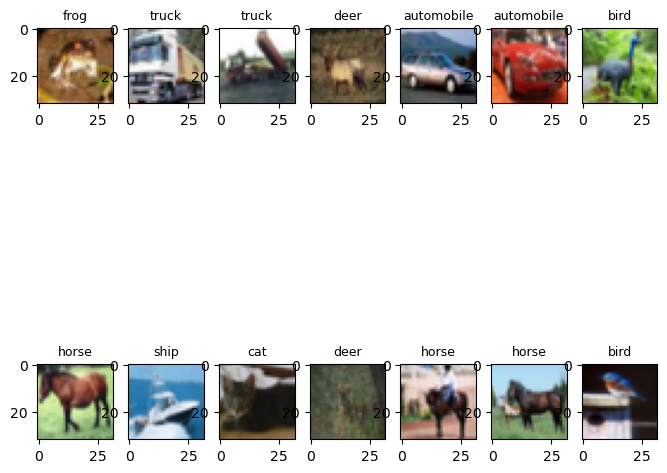

In [5]:
# plotting some examples from training dataset

plt.figure(figsize=(8, 8)) 
for i in range(2*7):
    # define subplot
    plt.subplot(2, 7, i+1)
    plt.imshow(x_train[i])
    class_index = np.argmax(to_categorical(y_train[i], 10))
    plt.title(class_names[class_index], fontsize=9)

In [6]:
tf.__version__

'2.10.0'

In [7]:
# convert data to HDF5 format

with h5py.File('dataset_cifar10.hdf5', 'w') as hf:
    dset_x_train = hf.create_dataset('x_train', data=x_train, shape=(50000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_train = hf.create_dataset('y_train', data=y_train, shape=(50000, 1), compression='gzip', chunks=True)
    dset_x_test = hf.create_dataset('x_valid', data=x_valid, shape=(10000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_test = hf.create_dataset('y_valid', data=y_valid, shape=(10000, 1), compression='gzip', chunks=True)

In [8]:
# Define the model

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.summary()

2023-10-05 23:06:16.110197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 23:06:16.228953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [9]:
# Define the data generator

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, filename, batch_size, test=False, shuffle=True):
        
        self.PATH_TO_FILE = filename
        
        self.hf = h5py.File(self.PATH_TO_FILE, 'r')         
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.on_epoch_end()

    def __del__(self):
        self.hf.close()
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start = self.batch_size * idx
        stop = self.batch_size * (idx+1)
        
        if self.test:
            x = self.hf['x_valid'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_valid'][start:stop]
            batch_y = to_categorical(np.array(y), 10)
        else:
            x = self.hf['x_train'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_train'][start:stop]
            batch_y = to_categorical(np.array(y), 10)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.test:
            self.indices = np.arange(self.hf['x_valid'][:].shape[0])
        else:
            self.indices = np.arange(self.hf['x_train'][:].shape[0])
            
        if self.shuffle:
            np.random.shuffle(self.indices)

In [10]:
# generate batches of data for training and validation dataset

filename = "dataset_cifar10.hdf5"
batchsize  = 250 
data_train = DataGenerator(filename, batch_size=batchsize, test=False)
data_valid = DataGenerator(filename, batch_size=batchsize, test=True, shuffle=False)

In [11]:
# defining optimizer for the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# first, let's train the model using CPU

with tf.device('/device:CPU:0'):
    history = model.fit(data_train,epochs=2,
                        verbose=1, validation_data=data_valid)

Epoch 1/2
200/200 [==============================] - 76s 378ms/step - loss: 1.7178 - accuracy: 0.3560 - val_loss: 1.3527 - val_accuracy: 0.5058
Epoch 2/2
200/200 [==============================] - 75s 375ms/step - loss: 1.2811 - accuracy: 0.5337 - val_loss: 1.2206 - val_accuracy: 0.5694


In [13]:
# now, lets try with GPU to compare its performance with CPU

from tensorflow.keras.models import clone_model
new_model = clone_model(model)
opt = keras.optimizers.Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


## train the new_model using GPU here:
with tf.device('/device:GPU:0'):
    new_history = new_model.fit(data_train,epochs=10, verbose=1, validation_data=data_valid)

Epoch 1/10


2023-10-05 23:09:06.465218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-10-05 23:09:06.747151: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 23:09:06.748021: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 23:09:06.748038: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-10-05 23:09:06.748693: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 23:09:06.748729: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 26s 122ms/step - loss: 1.7185 - accuracy: 0.3602 - val_loss: 1.5039 - val_accuracy: 0.4535
Epoch 2/10
200/200 [==============================] - 24s 122ms/step - loss: 1.2689 - accuracy: 0.5397 - val_loss: 1.1345 - val_accuracy: 0.5956
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 1.0646 - accuracy: 0.6220 - val_loss: 1.0485 - val_accuracy: 0.6310
Epoch 4/10
200/200 [==============================] - 24s 121ms/step - loss: 0.9045 - accuracy: 0.6793 - val_loss: 0.9174 - val_accuracy: 0.6783
Epoch 5/10
200/200 [==============================] - 24s 121ms/step - loss: 0.7804 - accuracy: 0.7262 - val_loss: 0.8211 - val_accuracy: 0.7064
Epoch 6/10
200/200 [==============================] - 24s 122ms/step - loss: 0.6892 - accuracy: 0.7590 - val_loss: 0.7999 - val_accuracy: 0.7201
Epoch 7/10
200/200 [==============================] - 24s 122ms/step - loss: 0.6059 - accuracy: 0.7867 - val_loss: 0.7664 - val_accuracy: 0.7

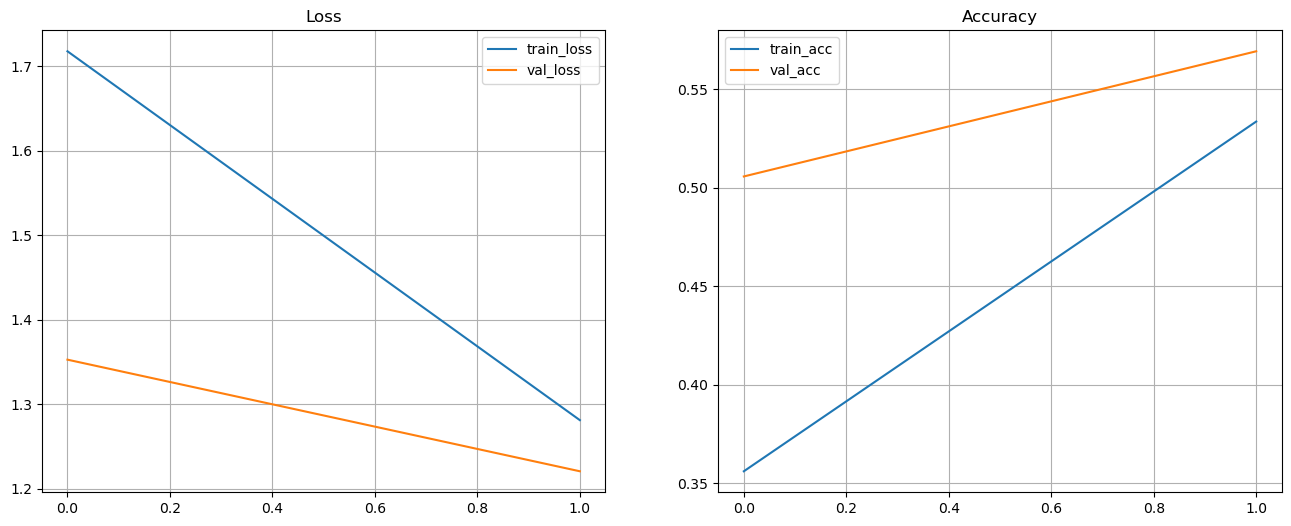

In [14]:
# plotting the losses and accuracy for training and validation set

fig, axes = plt.subplots(1,2, figsize=[16, 6])
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid()
axes[1].plot(history.history['accuracy'], label='train_acc')
axes[1].plot(history.history['val_accuracy'], label='val_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid()

In [15]:
x = x_valid.astype('float32') / 255.0
y = to_categorical(y_valid, 10)
score = new_model.evaluate(x, y, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

Test cross-entropy loss: 0.85213
Test accuracy: 0.74


In [17]:
y_pred=model.predict(x) 
y_pred_classes=np.argmax(y_pred,axis=1)

313/313 [==============================] - 0s 1ms/step


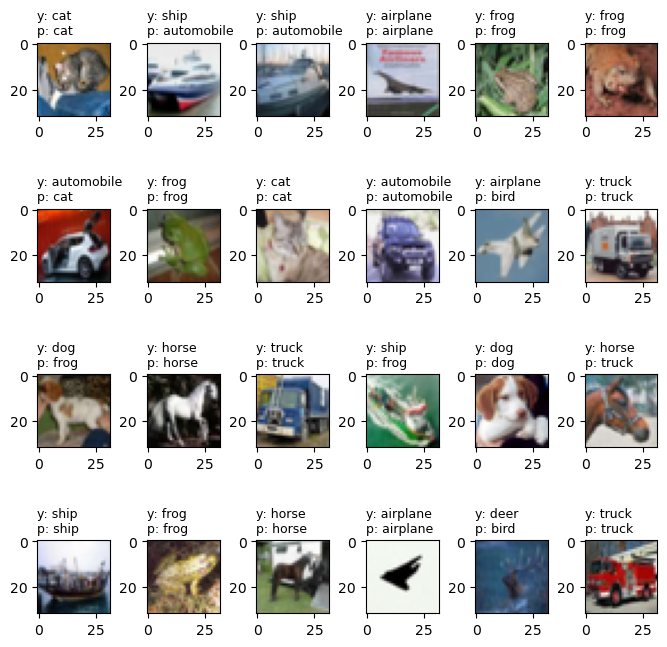

In [20]:
plt.figure(figsize=(8, 8)) 
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x[i].reshape(32,32,3))
    index1 = np.argmax(y[i])
    plt.title("y: %s\np: %s" % (class_names[index1], class_names[y_pred_classes[i]]), fontsize=9, loc='left')
    plt.subplots_adjust(wspace=0.5, hspace=0.4)

# Staging and File System Choice

##### Run this cell if you're not in your home directory

In [ ]:
cd

#### Challenge 1: Locate Lustre and NFS File System Scratch On MANA

In [ ]:
!pwd
!ls

#### Challenge 2: List Usage Information

In [ ]:
!usage